In [225]:
import glob, tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torch.optim as optim

import torch.nn.functional as F
from torch.autograd import Variable

import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages")

In [226]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.size = self.seq_len
        
    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [227]:
# naive bayes on stock direction
# match the ticker on that day with
df = pd.read_csv("./dataset/LSTM_input.csv")
print(len(df))
# convert to price going up or down
df["ret"] = df["ret"].apply(lambda x: 1 if x > 0 else -1 if x<0 else 0 )
df = df.rename(columns={"Ret_time": 'Date'})
print(df.head(5))

# replace Y with stock returns
def stock_return_mapper(ticker_location, input_ret, post):
    posttime_list    = []
    ticker_ret_list  = []
    for i in range(len(ticker_location)):
        ticker_list  = ticker_location.iloc[i].split(' ')
        post_i       = post.iloc[ticker_location.index[i]]['title']
    
        for ticker in ticker_list:
            posttime             = post.iloc[ticker_location.index[i]].name
            posttime_1d_later    = pd.to_datetime(posttime) + timedelta(1)
            posttime             = datetime.strftime(posttime_1d_later,'%Y-%m-%d')
            if posttime in input_ret.index:
                ticker_ret   = input_ret.loc[posttime,ticker]
                posttime_list.append(post_i)
                ticker_ret_list.append(ticker_ret)
    return posttime_list,ticker_ret_list

5139
   Unnamed: 0     Date ticker    pos    neu    neg  ret
0           0  1/29/21    AMC  0.119  0.881  0.000    1
1           1  1/29/21    NOK  0.000  0.837  0.163   -1
2           2  1/29/21    GME  0.000  0.837  0.163    1
3           3  1/29/21    AMC  0.000  0.837  0.163    1
4           4  1/29/21    GME  0.359  0.641  0.000    1


In [228]:
#df = df.set_index('Date')
#df.head(3)
#df.index = pd.to_datetime(df.index)

In [229]:
#df.groupby("Date")

In [230]:
#df.head(40)
#df = df.groupby(pd.Grouper(freq='D', level=0))# .count()

In [231]:
#max_post = df["ticker"].max()


In [232]:
#df['Date'] = df['Date'].apply(lambda x: x.Date()) # make date
dfs = [df[df['Date'] == date] for date in df['Date'].unique()] # group by date

In [233]:
X_data, y_data = [], [] # np.array((len(dfs),1)), np.array((len(dfs),1))
for ii, day_info in enumerate(dfs):
    X_data.append(day_info[["pos","neu","neg"]].to_numpy())
    y_data.append(day_info[["ret"]].to_numpy())
#X_data = np.array(X_data)
#y_data = np.array(y_data)

In [234]:
len(X_data[1])

202

### Split into Train, Test

In [267]:
num_examples = len(X_data)
num_train = int(num_examples * 0.8)
print(num_train)
X_train = X_data[:num_train]
y_train = y_data[:num_train]

X_test = X_data[num_train:]
y_test = y_data[num_train:]

my_seq = 1

print(" Length of X_train {0}".format(len(X_train)))
print(" Length of X_test {0}".format(len(X_test)))

train_dataset = TimeseriesDataset(X_train, y_train, seq_len=my_seq)
test_dataset = TimeseriesDataset(X_test, y_test, seq_len=my_seq)

92
 Length of X_train 92
 Length of X_test 24


### Data to Dataloader

In [268]:
BATCH_SIZE = 1

#num_examples = len(train_dataset)
#print(num_examples)
# why 98%?
#num_train = int(num_examples * 0.8)
#print(num_train)
#train_sampler = SubsetRandomSampler(torch.arange(num_train))

#### TRAIN
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              #sampler=train_sampler,
                              pin_memory=True,
                              drop_last=False)

#### TEST 
test_dataloader = DataLoader(test_dataset, 
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              #sampler=train_sampler,
                              pin_memory=True,
                              drop_last=False)

print(len(train_dataloader)*BATCH_SIZE)

92


### Set Model

In [269]:
class LSTM_Model(nn.Module):
    def __init__(self, 
                 input_size, 
                 output_size,
                 hidden_size=128):
        
        super(LSTM_Model, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.lstm   = nn.LSTM(self.input_size, 
                              self.hidden_size,
                              batch_first=True, 
                              num_layers=1) # If this is >1, this changes the output shape, FYI
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x):
        #h_0 = Variable(torch.zeros(
        #    1, len(x), self.hidden_size))
        
        #c_0 = Variable(torch.zeros(
        #    1, len(x), self.hidden_size))
        
        x, _ = self.lstm(x)#, (h_0, c_0))
        #h_out = h_n.view(-1, self.hidden_size)
        x = self.linear(x)
        
        #x, _ = self.lstm(x)
        #x = self.linear(x.squeeze)
        
        return x

In [277]:
def train(epochs, optimizer, criterion, device, train_dataloader, model):
    # See what the scores are before training
    # Note that element i,j of the output is the score for tag j for word i.
    # Here we don't need to train, so the code is wrapped in torch.no_grad()
    model = model.float()
    #data_test, label_test = next(iter(train_dataloader))
    #with torch.no_grad():
    #   tag_scores = model(data_test)
    #    print(tag_scores)
    
    #model.train(True)
    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        running_loss=0
        model.train(True)# (True)
        for i, data in enumerate(train_dataloader):
            # Every data instance is an input + label pair
            inputs, labels = data
            inputs = inputs[0]
            # Make predictions for this batch
            
            #print("my inputs")
            #print(inputs.shape)
            ##print(" my labels ")
            #print(labels.shape)
            
            outputs = model(inputs.float())
            '''
            c = []
            for bb in b:
                if bb<0:
                    bb=-1
                elif bb>0:
                    bb=1
                else:
                    bb=0
                c.append(bb)
            outputs = torch.Tensor([[c]])
            '''
            #outputs[outputs < 0] = -1.00
            #outputs[outputs > 0] = 1.000
            #print(len(outputs))
            # Zero your gradients for every batch!
            optimizer.zero_grad()
            
            # Compute the loss and its gradients
            loss = criterion(outputs.float(), labels.float())
            #print(loss.dtype)
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            running_loss += loss.item()
            
        if epoch % 10 == 0:
            print("output are ")
            print(outputs)
            ##print("inputs are ")
            #print(inputs)
            print(" labels are below ")
            print(labels)
        print(" Epoch {0}, train loss {1}".format(epoch, running_loss))
        running_loss=0
        

In [278]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight_file = "LSTM_Model.pt"

num_epochs = 200
learning_rate = 0.001

input_size = 3
hidden_size = 128*2
output_size = 1

model = LSTM_Model(input_size = input_size,  output_size = output_size)
model.to(device)

criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train Model

In [279]:
train(
    epochs=num_epochs,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    train_dataloader=train_dataloader,
    model=model
)

EPOCH 1:
output are 
tensor([[[ 0.0143],
         [-0.0030],
         [-0.0181],
         [-0.0271],
         [-0.0304],
         [-0.0317],
         [-0.0336],
         [-0.0347]]], grad_fn=<AddBackward0>)
 labels are below 
tensor([[[ 1],
         [ 1],
         [-1],
         [-1],
         [-1],
         [-1],
         [ 1],
         [ 1]]])
 Epoch 0, train loss 92.88548296689987
EPOCH 2:
 Epoch 1, train loss 92.03286123275757
EPOCH 3:
 Epoch 2, train loss 91.94757503271103
EPOCH 4:
 Epoch 3, train loss 91.88828998804092
EPOCH 5:
 Epoch 4, train loss 91.84621167182922
EPOCH 6:
 Epoch 5, train loss 91.81291592121124
EPOCH 7:
 Epoch 6, train loss 91.78618657588959
EPOCH 8:
 Epoch 7, train loss 91.76473593711853
EPOCH 9:
 Epoch 8, train loss 91.74979990720749
EPOCH 10:
 Epoch 9, train loss 91.72763156890869
EPOCH 11:
output are 
tensor([[[ 0.0266],
         [ 0.0158],
         [-0.0125],
         [-0.0363],
         [-0.0433],
         [-0.0443],
         [-0.0501],
         [-0.0535]

### Check Accuracy of Training and Test 

In [202]:
my_train_results = []
my_train_labels = []
print(len(train_dataloader))
model.train(False)

for i, data in enumerate(train_dataloader):
    # Every data instance is an input + label pair
    inputs, labels = data
    inputs = inputs[0]
    #print(inputs.shape)
    
    outputs = model(inputs.float())
    # convert to buy ( +1 ) or sell ( -1 )
    outputs[outputs < 0] = -1
    outputs[outputs > 0] = 1
    
    results = outputs[0].cpu().detach().numpy()
    label = labels[0].cpu().detach().numpy()
    
    #print(results.shape)
    
    my_train_results.append(results)
    my_train_labels.append(label)

92


In [179]:
my_test_results = []
my_test_labels = []
print(len(test_dataloader))
model.train(False)

for i, data in enumerate(test_dataloader):
    # Every data instance is an input + label pair
    inputs, labels = data
    inputs = inputs[0]
    #print(inputs.shape)
    
    outputs = model(inputs.float())
    # convert to buy ( +1 ) or sell ( -1 )
    outputs[outputs < 0] = -1
    outputs[outputs > 0] = 1
    
    results = outputs[0].cpu().detach().numpy()
    label = labels[0].cpu().detach().numpy()
    
    #print(results.shape)
    
    my_test_results.append(results)
    my_test_labels.append(label)
    
#my_test_res = [ 1 if xx[0] > 0 else -1 for xx in my_test_results]

#print(my_test_labels)

24


In [216]:
def getAcc(l1, l2):
    day_counter = []
    acc_res = []
    tot_corr_counter = 0
    tot_comments = 0
    tot_acc = 0
    for ii, (lab1, lab2) in enumerate(list(zip(l1,l2))):
        true_prediction = np.sum([l1==l2 for l1, l2 in zip(lab1,lab2)])
        tot_corr_counter+=true_prediction
        number_comments = len(lab2)
        tot_comments+=number_comments
        daily_acc = true_prediction/number_comments 
        #print(" Daily Acc {0:.3g} Number of correct pred {1} out of size {2} ".format(daily_acc,true_prediction, number_comments))
        day_counter.append(ii)
        acc_res.append(daily_acc)
    tot_acc = tot_corr_counter/tot_comments
    return day_counter, acc_res, tot_acc

In [217]:
# training accuracy
train_day_counter, train_acc_res, train_tot_acc = getAcc(my_train_results, my_train_labels)


# testing accuracy
day_counter, acc_res, tot_acc = getAcc(my_test_results, my_test_labels)

Total Accuracy in Training Data is 0.80235


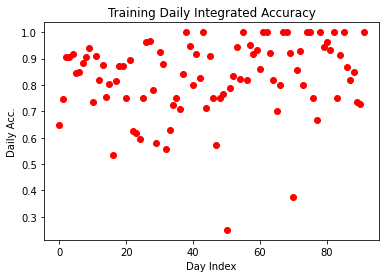

Total Accuracy in Test Data is 0.46575


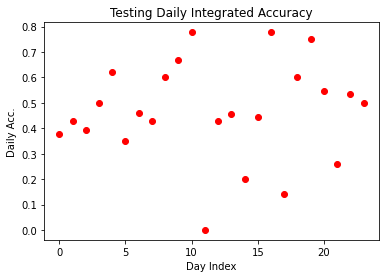

In [280]:
print("Total Accuracy in Training Data is {0:.5g}".format(train_tot_acc))
plt.title("Training Daily Integrated Accuracy")
plt.xlabel("Day Index")
plt.ylabel("Daily Acc.")
plt.scatter(train_day_counter, train_acc_res, c='r')
plt.show()

print("Total Accuracy in Test Data is {0:.5g}".format(tot_acc))
plt.title("Testing Daily Integrated Accuracy")
plt.xlabel("Day Index")
plt.ylabel("Daily Acc.")
plt.scatter(day_counter, acc_res, c='r')

In [ ]:
# dont have enough history in the dataset 